### Preaamble

In [1]:
import sys
sys.path.append('../src/')
from preamble import *

'Loaded typical imports v 0.0.1'


In [2]:
import IFTA as bidirect

In [3]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=12)
from matplotlib.patches import Wedge
from matplotlib import patches

In [4]:
# Required for plotting Figure from paper, if not install skip plot_does_paper function
# install pacakge [matplotlib-scalebar] with conda or pip
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL

# Designing a ring in the reciprocal k-space

We are going to established different rules to generate a QR. We have to find the suitable rule to generate different structure. We will use the effective refractive index to understand the rules.



In [5]:
# For the design we have not taken in account the dispersion of the materials. We use fixed values.
n_front = 1.0
n_back = 1.4 # We assume a fixed SiO2 1.4, lower limit.
n_active = 3.6
# The PC is made between SiO2

## Selection of the wavelength to use

We limit the ring to two fundamental wavelengths, 
the band-gap + Urbach Tail of the semiconductor and the full absorption of the structure (100 nm GaAs layer). 
$l_1 = 900 nm$, $l_2 = 440 nm$. With this values we define the $k_1,k_2$ as the $R$ and $r$ for the ring. Therefore:

\begin{equation}
k_1 = 1/l_1,\\
k_2 = 1/l_2.
\end{equation}

The spatial frequencies will be scaled using the effective refractive index of the layer.
Therefore:
\begin{equation}
k_{1,m} = n_{m} k_{1,0},\\
k_{2,m} = n_{m} k_{2,0}.
\end{equation}

In [6]:
l1 = 0.9 # Bandgap + Urbach Tail
l2 = 0.440 # Single pass with absorption > 95 %
k1 = 1/l1
k2 = 1/l2
k_i = np.array([k1,k2]) * n_front# k in the inc. medium
k_t = np.array([k1,k2]) * n_back# k in the tran. medium
k_c = np.array([k1,k2]) * n_active# using the active

In [7]:
# As we are going to work on transmission we use the k_t with the SiO2
k_q = k_t

## Lattice Parameter Rules

We have to select the lattice parameter. We can define different rules to established it.
First of all, we want to see the progression from a conventional PC to a QR-PC structure. Therefore, somehow we have to increase the number o diffracted orders between, $k_1$ and $k_2$. Each diffracted order is spaced $k_a$ being, $k_a = 1/a$. Increasing the lattice parameter we increase the number of orders inside the ring, as we are joining more orders together. 


**Rule $\Delta m = 0$:**

We want the first diffracted order between $k_2$ and $k_1$. Therefore 
\begin{equation}
\label{eq:krule0}
k_a= (k_2 + k_1) / 2.
\end{equation}

**Rule $\Delta m \geq 0$:**

We want to increase the number of orders $\Delta m$, so we establish $k_a$ by dividing linearly the number of orders ($R-r$).

\begin{equation}
\label{eq:krule1}
k_a= (k_2 - k_1) / \Delta m.
\end{equation}


(We use $k_a = 1/a$ for simplicity/numeric but it is equivalent to $k_a = 2\pi / a$ if the constant $2 \pi$ is removed/added in all the steps.)



####  Functions

In [8]:
def qrule(k_int, k_ext, delta_m=1):
    """ Function that generates the rule for creating the Q space
    k_int (float): interior radious in microns^-1
    k_ext (float): exterior radious in microns^-1
    delta_m (int)
    """
    if delta_m == 0:
        ka = (k_int +  k_ext) / 2
    else:
        ka = (k_ext - k_int) / delta_m
    return ka

In [9]:
def apply_LUT(I, LUT1, LUT2):
    """ Dummy function to apply two LUTs"""
    I[LUT1] = 0.
    I[LUT2] = 0.
    # no need for return write directly

def create_DOEs(Q, M=2, steps=200, seed=23):
    """ Function to create the structure with objective Q using the function from IFTA
    Q(np.array NxN): Matrix containing the target Q
    M (int): multiplier for the zero-padding frame. The final targe matrix rank is [2*N+1 + M*N].
    seed (int): Seed used in the numpy random to generate the phase.
    """
    F_WA, Q_WA, error_WA = bidirect.WA_A(Q, M=M, steps=steps, seed=seed)
    Q_WA = abs(Q_WA) / abs(Q_WA).max()
    DOE = dict(F=F_WA,Q=Q_WA,error=error_WA)
    return DOE

In [10]:
#from pyphotonics.utils import images as simages
def generate_qr(a, k_int, k_ext,  M=10, steps=200, seed=23): #23 is just my cake day
    """ Function to generate the QR for a lattice parameter a, a k_int and k_ext.
    a (float): lattice in microns.
    k_int (float): interior radious in microns^-1
    k_ext (float): exterior radious in microns^-1
    M (int): Zero-Padding frame used for the structure.
    steps (int): steps to do the iteration
    seed (int): Initial seed for the random generator of numpy.
    """
    r1 = k_int #* n_doe #n_doe / l1
    r2 = k_ext #* n_doe #n_doe / l2
    N = int(np.round(r2 * a, 0)) + 1 # + 1 # Longest radius/samples x microns -1
    sN = 2 * N + 1
    R1 = r1 * a
    R2 = r2 * a 
    conditions = dict(a=a, R1=R1,R2=R2,M=M)
    # We create the Q(qx,qy) 
    x, y = np.meshgrid(np.arange(-N, N + 1), np.arange(-N, N + 1))
    Q = np.ones((2 * N + 1, 2 * N + 1))
    LUT1 = x ** 2 + y ** 2 <= R1 ** 2
    Q[LUT1] = 0.
    LUT2 = x ** 2 + y ** 2 > R2 ** 2
    Q[LUT2] = 0.
    Q = Q/Q.max()
    #print(i+1, Q.sum())
    # Let' create the DOE
    L = create_DOEs(Q, M=M, steps=steps, seed=seed)
    print("Sizes", Q.shape, L['F'].shape)
    return L, Q, conditions

## Generating the L (real space) from the Q (reciprocal space)

In [11]:
k_int = k_q[0] # The  interior radius circle
k_ext = k_q[1]

In [12]:
delta_m = np.array([0, 1, 2, 3, 4], dtype='float64')
kas = np.zeros_like(delta_m)

for i, m_i in enumerate(delta_m):
    ka = qrule(k_int, k_ext, delta_m=m_i)
    kas[i] = ka
a_s = 1. / kas ## We do not rescale twice the k
print("Lattice parameter (microns)")
print (a_s)

Lattice parameter (microns)
[0.4222 0.6149 1.2298 1.8447 2.4596]


Sizes (5, 5) (45, 45)
Sizes (7, 7) (67, 67)
Sizes (11, 11) (111, 111)
Sizes (15, 15) (155, 155)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Sizes (19, 19) (199, 199)


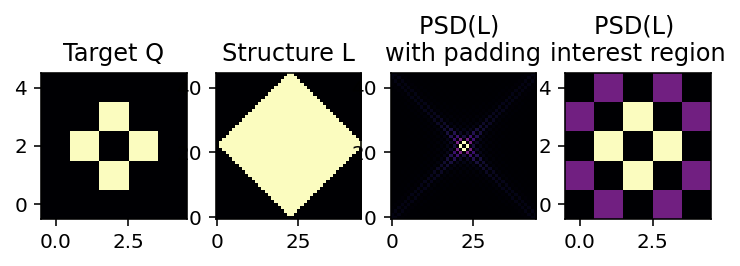

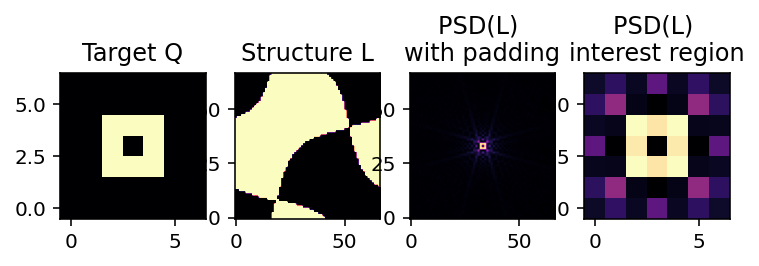

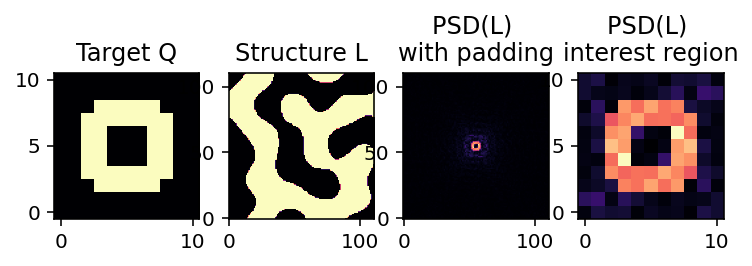

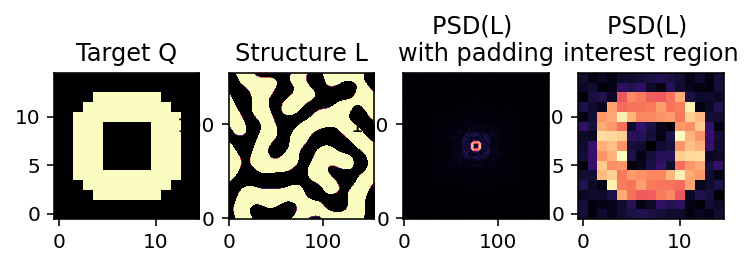

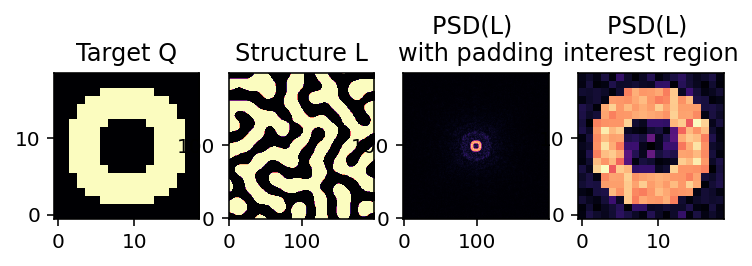

In [13]:
Ls = []
CONDs = []
Qs = []
seed = 2
for i, a in enumerate(a_s):  
    L, Q, conditions = generate_qr(a, k_int, k_ext, M=10)
    Ls.append(L)
    CONDs.append(conditions)
    Qs.append(Q)
    ## PLOTTTING
    # Plotting uncomment for seeing each iteration 
    F_WA = L['F']
    Q_WA = np.fft.fft2(F_WA)
    Q_WA[0,0] = 0 # We remove the 0th order for plotting
    Q_WA = np.abs(np.fft.fftshift(Q_WA)) # Re-center
    Q_WA = Q_WA/Q_WA.max() # We normalize the Q
    N = Q.shape[0]/2 
    sN = Q.shape[0]
    # We have to zoom into the Zero-padding for plotting Q
    MN = (Q_WA.shape[0] - 1 )//2
    sNM = (2*MN + 1) // a
    # Window to check
    win2 = [(Q_WA.shape[0] - Q.shape[0])//2,
            (Q_WA.shape[0] - Q.shape[0])//2 + Q.shape[0]]
    settings = {"cmap":"magma", "vmin":0, "vmax":1,
                "origin":"lower",}
    fg, ax = plt.subplots(1,4)
    ax[0].set_title('Target Q')
    ax[0].imshow(Q, **settings)
    ax[1].set_title('Structure L')
    ax[1].imshow(L['F'], **settings)
    ax[2].set_title('PSD(L) \nwith padding')
    ax[2].imshow(Q_WA, **settings)
    ax[3].set_title('PSD(L) \ninterest region')
    ax[3].imshow(Q_WA[win2[0]:win2[1], win2[0]:win2[1]], **settings)

In [14]:
def plot_does_paper(Is, DOEs, a_s, title1, title2, scales_r, scales_k,  cmap1='magma',
                    cmap2='binary', ncols=5, 
                    ltop_as = "", ltop_bs= "", **kwargs,
                     ):
    """It returns the figures for Fig.1 with Q and L for each Delta m"""
    fontprops = fm.FontProperties(size=12)
    plt.rcParams['font.size']=9
    plt.rcParams['svg.fonttype']='none'
    figsize = kwargs.get('figsize', (7.48, 2.7)) 
    
    fg, ax = plt.subplots(nrows=2, ncols=ncols, figsize=figsize)
    ii = range(ncols)
    for i, I, DOE, a in zip(ii, Is, DOEs, a_s):
        F_WA = DOE['F']
        I_WA = DOE['Q']
        I_WA = np.fft.fft2(F_WA)
        I_WA[0,0] = 0
        I_WA = np.abs(np.fft.fftshift(I_WA))
        I_WA = I_WA/I_WA.max()
        N = I.shape[0]/2 
        sN = I.shape[0]
        # We have to zoom into the Zero-padding for plotting Q
        MN = (I_WA.shape[0] - 1 )//2
        sNM = (2*MN + 1) // a
        win2 = [(I_WA.shape[0] - I.shape[0])//2,
                (I_WA.shape[0] - I.shape[0])//2 + I.shape[0]]
        xlim = [-a / 2., a / 2.   ]
        xftlim = np.array([-sN // 2 , sN // 2 +1] * 2) /a
        xftlim2 = np.array([-sNM // 2, sNM // 2+1] * 2) /a
        ax1 = ax[0,i]
        ax2 = ax[1,i]
        
        ax1.text(1., 1.03, title1[i], fontsize=10, horizontalalignment='right',
                  verticalalignment='bottom', transform=ax1.transAxes) 

        ax1.text(-.05, 1.03, ltop_as[i], fontsize=11, horizontalalignment='left',
                  verticalalignment='bottom', transform=ax1.transAxes) 

        ax2.text(1., 1.02, title1[i], fontsize=10, horizontalalignment='right',
                  verticalalignment='bottom', transform=ax2.transAxes) 

        ax2.text(-.05, 1.02, ltop_bs[i], fontsize=11, horizontalalignment='left',
                  verticalalignment='bottom', transform=ax2.transAxes) 
    
        im1 = ax1.imshow(
            abs(I_WA[win2[0]:win2[1], win2[0]:win2[1]]), #interpolation='nearest',
                extent=xftlim,
                cmap=cmap1,
                vmin=0,vmax=1)
        im2 = ax2.imshow(F_WA.real / np.pi, #interpolation='nearest',
                         extent=xlim * 2,
                         origin='lower',
                         cmap=cmap2)

        label_formatter = lambda x,y: ""
        scalebar1 = ScaleBar(1,units='1/um',dimension=SI_LENGTH_RECIPROCAL, 
                             height_fraction=0.05,
                             fixed_value=scales_k[i],
                             box_alpha=0.,
                             box_color='k',
                             #frameon=True,
                             color='w',
                            label_formatter=label_formatter)
        ax1.add_artist(scalebar1)
        [axi.set_xticks([]) for axi in[ax1,ax2]]
        [axi.set_xticklabels([]) for axi in[ax1,ax2]]
        [axi.set_yticks([]) for axi in[ax1,ax2]]
        [axi.set_yticklabels([]) for axi in[ax1,ax2]]
        
        ax2.annotate('', xy=(0, -0.08), xycoords='axes fraction', xytext=(1, -0.08), 
                     arrowprops=dict(arrowstyle="<->", color='k'))
        ax2.text(0.5, -0.19, title2[i], fontsize=10, horizontalalignment='center',
                  verticalalignment='center', transform=ax2.transAxes,) 
    #fg.tight_layout()
    sbot = kwargs.get("sbot",0.05)
    stop = kwargs.get("stop",0.9)
    fg.subplots_adjust(left=0.01,bottom=sbot, top=stop,right=0.99)
    cb = fg.colorbar(im1, ax=ax[0,:].ravel().tolist(), pad=0.01, aspect = 30, label="|FT|$^2$")
    cb = fg.colorbar(im2, ax=ax[1,:].ravel().tolist(), pad=0.01, aspect = 30, label="Phi/$\pi$")

    #algaas = patches.Patch(facecolor='black', edgecolor='black', label='AlGaAs')
    #vacuum = patches.Patch(facecolor='white', edgecolor='black', label='SiO$_2$')
    #ax[1,-1].legend(loc=2,bbox_to_anchor=(1,1.1),frameon=False,handles=[algaas, vacuum])
    return fg

0.4221748400852878
0.6149068322981366
1.2298136645962732
1.8447204968944098
2.4596273291925463


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


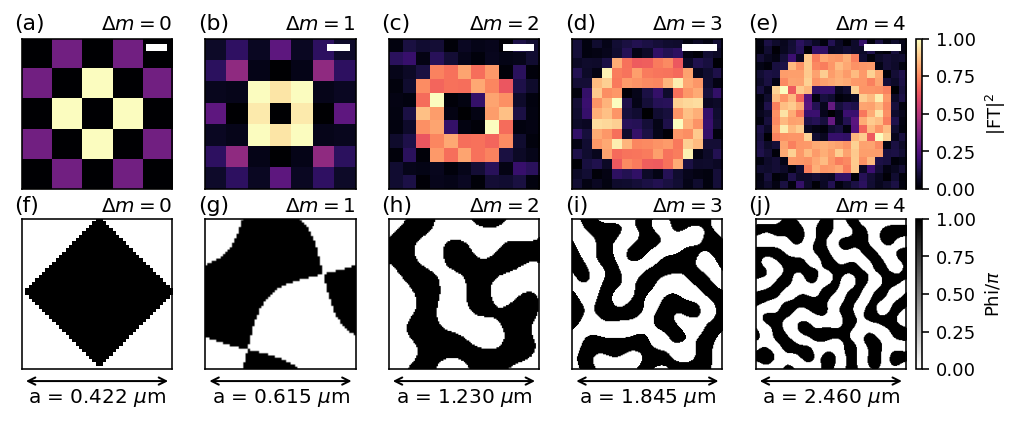

In [15]:
scale_rs = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 4]
label_aleft = 'abcde'
label_bleft = 'fghij'
titles1 = []
titles2 = []
ltopsa = []
ltopsb = []
scales = [0.1, 0.25, 0.5, 0.75, 1.]
scales = [0.4, 0.4, 0.4, 0.4, .4]
for i, a in enumerate(a_s):
    title1 = "$\Delta m={0}$".format(int(delta_m[i]),0)
    title2 = f"a = {a:.3f} $\mu$m"
    ltop_a = '({})'.format(label_aleft[i])
    ltop_b = '({})'.format(label_bleft[i])
    ltopsa.append(ltop_a)
    ltopsb.append(ltop_b)
    titles1.append(title1)
    titles2.append(title2)
    print(a)
fg2  = plot_does_paper(Qs, Ls, a_s, titles1,titles2, 
                        ltop_as=ltopsa,
                        ltop_bs=ltopsb, scales_r=scales, scales_k=[2]*5)
fg2.savefig('../figures/Fig_K_Growth.pdf', dpi=600, bbox_inches='tight')

### Saving the Structures

In [16]:
## Used for saving the structures as images
# If not installed use pip or conda 
import skimage.io
def saver_image(saveas, DOE):
    A = DOE['F']/DOE['F'].max()
    A = np.array( A * 255,dtype=np.uint8)
    im = skimage.io.imsave(saveas+".png", A)

In [17]:
for ii, L in enumerate(Ls):
    saver_image("../figures/ls/" +  "qr_{0}_s{1}".format(ii,0), L)

# END

The structures are saved as .png bitmaps so can be loaded on the EM solver.

# Appendix: Example design of Q with two delta m

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


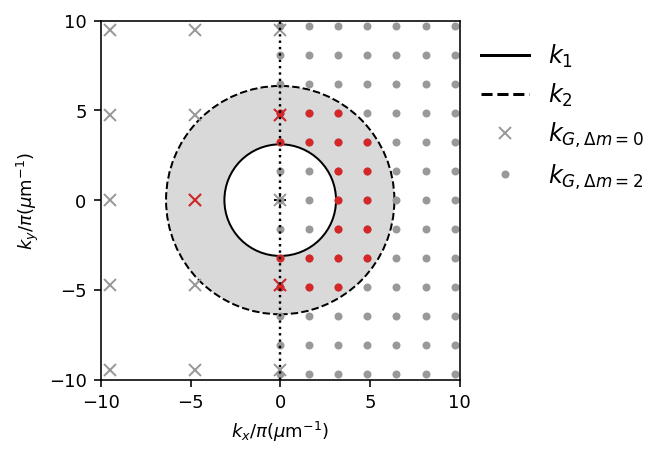

In [18]:
def plot_bragg_harmonics(ks, kal=0.4, kar=0.4):
    fig, axes = plt.subplots(1,1,figsize=(3.3,3.3)) 
    axes = [axes]
    colors = ['C0', 'C0', 'C3']
    linestyles=['-','-.', '--']
    axes[0].plot([0],[0], '+', color='k')
    #labels = ['k$_0$', 'k$_{\mathrm{SiO}_2}$', 'k$_\mathrm{GaAs}$']
    i = 1
    color_c =['0.9', 'w']
    
    axes[0].plot([0,0],[0,0], '-', color='k',label='$k_1$')
    axes[0].plot([0,0],[0,0], '--', color='k',label='$k_2$')
    
    circle1 = plt.Circle((0,0), ks[1], fill=True, edgecolor='k', linestyle='--', facecolor='0.85', label='$k_2$')
    axes[0].add_artist(circle1)
    
    circle1 = plt.Circle((0,0), ks[0], fill=True, facecolor='white', edgecolor='k',linestyle='-', label='$k_1$')
    axes[0].add_artist(circle1)
    
    
    ring = Wedge((0,0),ks[1],360,360, width=ks[1]-ks[0])
    axes[0].add_artist(ring)
    
    xc = np.arange(-100,100,1) * kal
    Xc, Yc = np.meshgrid(xc,xc)
    axes[0].plot(Xc[Xc<=0],Yc[Xc<=0],'x', color='0.6', label='$k_{G,\Delta m=0}$')
    lutA = Xc**2 + Yc**2 >= ks[0]**2
    lutB = Xc**2 + Yc**2 <  ks[1]**2
    lut = (lutA  * lutB) * (Xc <=0)
    axes[0].plot(Xc[lut],Yc[lut],'x', color='C3')
    
    xc = np.arange(-100,100,1) * kar
    Xc, Yc = np.meshgrid(xc,xc)
    axes[0].plot(Xc[Xc>=0],Yc[Xc>=0],'.', color='0.6', label='$k_{G,\Delta m=2}$')
    lutA = Xc**2 + Yc**2 >= ks[0]**2
    lutB = Xc**2 + Yc**2 <  ks[1]**2
    lut = (lutA  * lutB) * (Xc >=0)
    axes[0].plot(Xc[lut],Yc[lut],'.', color='C3')
    
        
    axes[0].axis('scaled')
    axes[0].set_xlabel(r'$k_x/\pi$($\mu$m$^{-1}$)')
    axes[0].set_ylabel(r'$k_y/\pi$($\mu$m$^{-1}$)')
    axes[0].legend(loc=2, bbox_to_anchor=(1,1),  frameon=False, fontsize=12)
#


    axes[0].set_ylim(-1,1)

    axes[0].set_xticks([-10.0, -5,   0,5, 10])
    axes[0].set_yticks([-10.0, -5,   0,5, 10])
    axes[0].set_ylim(-10,10)
    axes[0].set_xlim(-10,10)

    return fig, axes

ks = k_t[:2]

fig, axes = plot_bragg_harmonics(k_t*2, kal=2.36969*2, kar=1.62)
#axes[0].axhline(0, color='k')
axes[0].axvline(0, color='k', linestyle='dotted', linewidth=1.2)
fig.savefig('../figures/target_design.svg', bbox_inches='tight')
#fig.savefig('../reports/Fig_rings_kb.pdf', dpi=600, bbox_inches='tight')